# How to Further Train a Pre-Trained Model

### Loading Libraries

In [160]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd
import pandas_datareader.data as web

# Data Visualization
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Warnings
import warnings

# Path & OS
import os
import sys
from time import time
from pathlib import Path
from random import randint
from collections import defaultdict

# TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [61]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [63]:
results_path = Path('results', 'transfer_learning')

if not results_path.exists():
    results_path.mkdir(parents=True)

In [65]:
sns.set_style('whitegrid')

### Loading TensorFlow Cats vs Dog Dataset

In [68]:
tfds.list_builders()

2025-05-02 14:43:25.442950: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'ai2dcaption',
 'aloha_mobile',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asimov_dilemmas_auto_val',
 'asimov_dilemmas_scifi_train',
 'asimov_dilemmas_scifi_val',
 'asimov_injury_val',
 'asimov_multimodal_auto_val',
 'asimov_multimodal_manual_val',
 'asqa',
 'asset',
 'assin2',
 'asu_table_top_converted_externally_to_rlds',
 'austin_buds_dataset_converted_externally_to_rlds',
 'austin_sailor_dataset_converted_externally_to_rlds',
 'austin_sirius_dataset_converted_externally_to_rlds',
 'bair_robot_pushing_small',
 'bc_z',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'berkeley_autolab_ur5',
 'berkeley_cable_routing',
 'berkeley_fanuc_manipulation',
 'berkeley_gnm_cory_hall',
 'berkeley_gnm_recon',
 'berkeley_gnm_sac_son',
 'berkeley_mvp_converted_externally_to_rlds',
 'berkeley_rpt_converted_externally_to_rlds',
 'big_patent',
 'bigearthnet',
 'billsum',
 '

In [72]:
# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     'cats_vs_dogs',
#     split=[
#         tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
#         tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
#         tfds.Split.TRAIN.subsplit(tfds.percent[90:])
#     ],
#     with_info=True,
#     as_supervised=True,
#     data_dir='../data/tensorflow'
# )

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=[
        'train[:80%]',
        'train[80%:90%]',
        'train[90%:]'
    ],
    with_info=True,
    as_supervised=True,
    data_dir='../data/tensorflow'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

2025-05-02 14:44:19.703750: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-02 14:44:19.703774: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-02 14:44:19.703777: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-02 14:44:19.703789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-02 14:44:19.703798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corr

Shuffling ../data/tensorflow/cats_vs_dogs/incomplete.BTG79K_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%|      …

Dataset cats_vs_dogs downloaded and prepared to ../data/tensorflow/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [74]:
print('Raw train:\t', raw_train)

print('Raw validation:\t', raw_validation)

print('Raw test:\t', raw_test)

Raw train:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw validation:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Raw test:	 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


#### Showing Sample Images

2025-05-02 14:52:38.375765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


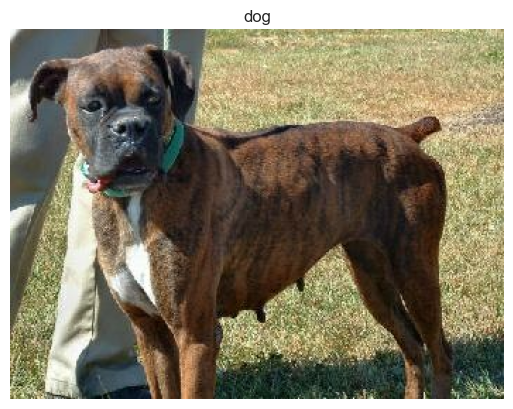

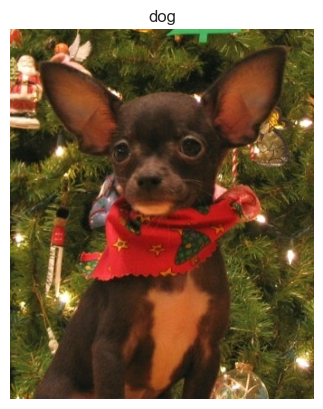

In [77]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.grid(False)
    plt.axis('off')

### Preprocessing

In [80]:
IMG_SIZE = 160

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [82]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [84]:
train = raw_train.map(format_example)

validation = raw_validation.map(format_example)

test = raw_test.map(format_example)

In [86]:
BATCH_SIZE = 32

SHUFFLE_BUFFER_SIZE = 1000

In [88]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

validation_batches = validation.batch(BATCH_SIZE)

test_batches = test.batch(BATCH_SIZE)

In [90]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

2025-05-02 14:52:46.804616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([32, 160, 160, 3])

### Loading The VGG-16 Bottleneck Features

In [93]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [95]:
feature_batch = vgg16(image_batch)

feature_batch.shape

TensorShape([32, 5, 5, 512])

### Freeze Model Layers

In [98]:
vgg16.trainable = False

In [100]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Adding New Layers to Model

#### Using The Sequential Model API

In [103]:
global_average_layer = GlobalAveragePooling2D()

dense_layer = Dense(64, activation='relu')
dropout = Dropout(0.5)
prediction_layer = Dense(1, activation='sigmoid')

In [105]:
seq_model = tf.keras.Sequential([vgg16, 
                                 global_average_layer, 
                                 dense_layer, 
                                 dropout, 
                                 prediction_layer])

In [107]:
seq_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                       optimizer = 'Adam', 
                       metrics=["accuracy"])

In [109]:
seq_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Using The Functional Model API

In [112]:
x = vgg16.output

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

In [114]:
transfer_model = Model(inputs = vgg16.input, 
                       outputs = predictions)

In [116]:
transfer_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                       optimizer = 'Adam', 
                       metrics=["accuracy"])

In [118]:
transfer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Computing Baseline Metrics

In [121]:
initial_epochs = 10
validation_steps=20

initial_loss, initial_accuracy = transfer_model.evaluate(validation_batches, steps = validation_steps)

/opt/anaconda3/envs/MLAT/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2025-05-02 14:53:06.756466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6760 - loss: 0.6289  


In [122]:
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

Initial loss: 0.63 | initial_accuracy accuracy: 68.12%


### Training VGG16 Transfer Model

In [126]:
history = transfer_model.fit(train_batches,
                             epochs=initial_epochs,
                             validation_data=validation_batches)

Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 31s 52ms/step - accuracy: 0.8225 - loss: 0.3653 - val_accuracy: 0.9256 - val_loss: 0.1745
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.9302 - loss: 0.1684 - val_accuracy: 0.9385 - val_loss: 0.1484
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.9354 - loss: 0.1553 - val_accuracy: 0.9351 - val_loss: 0.1577
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 33s 56ms/step - accuracy: 0.9388 - loss: 0.1483 - val_accuracy: 0.9411 - val_loss: 0.1407
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.9404 - loss: 0.1437 - val_accuracy: 0.9390 - val_loss: 0.1481
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 58ms/step - accuracy: 0.9400 - loss: 0.1452 - val_accuracy: 0.9437 - val_loss: 0.1376
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.9384 - loss: 0.1456 - val_accuracy: 0.9433 - val_loss: 0.1380
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9421 - loss: 0.1453 - 

#### Plotting Learning Curves

In [129]:
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['loss', 'val_loss']].plot(ax=axes[0], title='Cross-Entropy')
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    sns.despine()        
    fig.tight_layout();

In [131]:
metrics = pd.DataFrame(history.history)

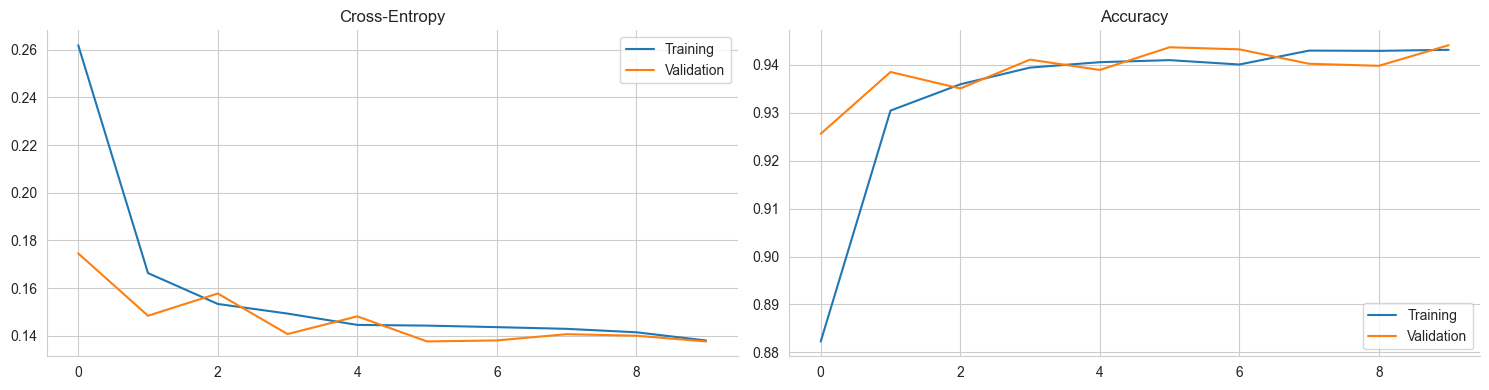

In [133]:
plot_learning_curves(metrics)

### Fine-Tune VGG16 Weights

#### Unfreezing Selected Layers

In [136]:
vgg16.trainable = True

In [138]:
f'Number of layers in the base model: {len(vgg16.layers)}'

'Number of layers in the base model: 19'

In [140]:
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [144]:
base_learning_rate = 0.0001

transfer_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=['accuracy']
)

#### Defining Callbacks

In [147]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

In [149]:
transfer_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 160, 160, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 160, 160, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 80, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 80, 80, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 40, 40, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 40, 40, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 20, 20, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 20, 20, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 11,831,937 (45.14 MB)

 Non-trainable params: 2,915,648 (11.12 MB)

### Keeping Training

In [152]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_batches,
                                       epochs=total_epochs,
                                       initial_epoch=history.epoch[-1],
                                       validation_data=validation_batches,
                                       callbacks=[early_stopping])

Epoch 10/60


/opt/anaconda3/envs/MLAT/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


582/582 ━━━━━━━━━━━━━━━━━━━━ 49s 82ms/step - accuracy: 0.9438 - loss: 0.1453 - val_accuracy: 0.9592 - val_loss: 0.1098
Epoch 11/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 51s 87ms/step - accuracy: 0.9736 - loss: 0.0709 - val_accuracy: 0.9647 - val_loss: 0.1151
Epoch 12/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - accuracy: 0.9860 - loss: 0.0413 - val_accuracy: 0.9488 - val_loss: 0.2021
Epoch 13/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 59s 102ms/step - accuracy: 0.9907 - loss: 0.0242 - val_accuracy: 0.9690 - val_loss: 0.1110
Epoch 14/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 117ms/step - accuracy: 0.9961 - loss: 0.0129 - val_accuracy: 0.9703 - val_loss: 0.1201
Epoch 15/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 67s 114ms/step - accuracy: 0.9984 - loss: 0.0072 - val_accuracy: 0.9690 - val_loss: 0.1482
Epoch 16/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 66s 113ms/step - accuracy: 0.9983 - loss: 0.0062 - val_accuracy: 0.9690 - val_loss: 0.1448
Epoch 17/60
582/582 ━━━━━━━━━━━━━━━━━━━━ 64s 110ms/step - accuracy: 0.9987 - loss: 0.0043 -

In [156]:
# metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)

metrics_tuned = pd.concat([metrics, pd.DataFrame(history_fine_tune.history)], ignore_index=True)

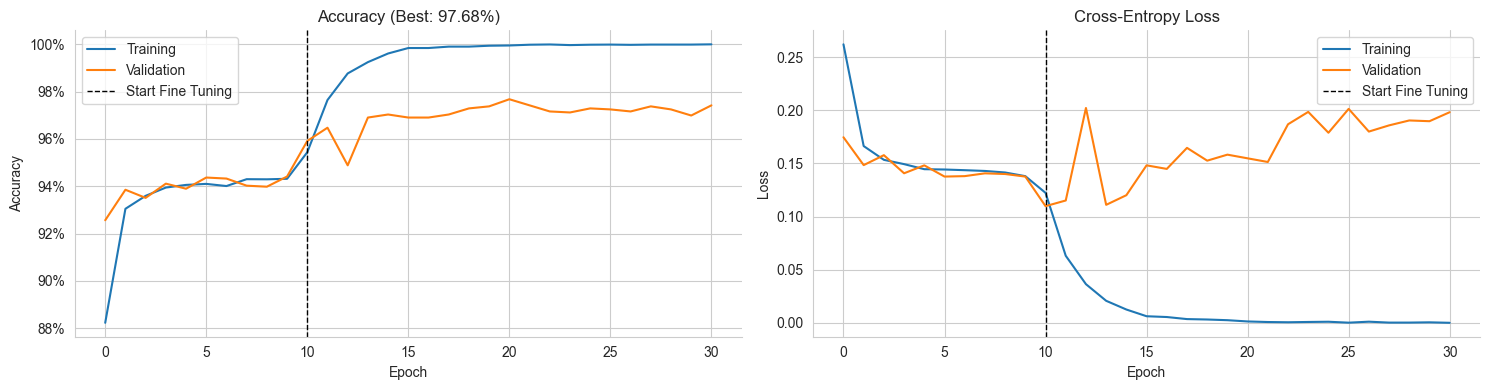

In [162]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(10, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
sns.despine()    
fig.tight_layout()
fig.savefig(results_path / 'transfer_learning');
plt.show()